# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given a SARS-CoV-2 assay. [Postera.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

Each model was constructed with a Pipeline of SMOTE and StandardScaler, which were used for rebalancing and scaling the data, respectively. Then, Stratified K-Fold was used for training and cross-validating the model. Finally, roc_auc_score, geometric_mean_score and f2_score were used as metrics for choosing the best set of descriptors for each classifier (XGBClassifier, RandomForestClassifier, etc.). 

The best model was KNeighborsClassifier, which had the highest Area Under the Curve (considering the ROC), followed by RandomForestClassifier and XGBClassifier. All models significantly outperformed the docking scoring functions. 

## Results
The results are presented in [ML_results.ipynb](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/ML_results.ipynb). Also, the top 3 models were reconstructed and used for classifying new compounds ([predict_activity.ipynb](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/predict_activity.ipynb)), presenting high AUC as well, though early recognition is still a challenge. 

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

0. [Imports](#imports)    
1. [Reading the data](#reading)    
    1. [Activity data](#activity)    
    2. [Molecular descriptors](#descriptors)
    3. [Read docking results](#read_docking)
2. [Selecting molecular descriptors](#selecting)
3. [Visualizing the data](#visualizing)
4. [Supplementary data](#supplementary)   
    1. [Regression plot](#regression)    
    2. [Test for class-independent features](#independent)

<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='reading'></a>
## Reading the data
<a id='activity'></a>
### Activity data

In [2]:
files = '../files'

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.000000,0.714452
f_inhibition_at_50_uM,0.714452,1.000000


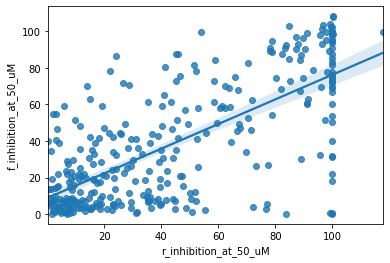

In [3]:
def write_data(name):
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open(name, 'wb') as f:
        f.write(r.content)

# Fetch activity data
write_data(f'{files}/activity_data.csv')

# Read activity data
activity = pd.read_csv(f'{files}/activity_data.csv')
#tmp = activity.query('r_inhibition_at_50_uM > 0 and r_inhibition_at_50_uM < 100 \
#    and f_inhibition_at_50_uM > 0 and f_inhibition_at_50_uM < 100')
tmp = activity.query('r_inhibition_at_50_uM > 0 and f_inhibition_at_50_uM > 0')

# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(data=tmp, x='r_inhibition_at_50_uM', y='f_inhibition_at_50_uM')
tmp[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

<AxesSubplot:xlabel='f_inhibition_at_50_uM', ylabel='Count'>

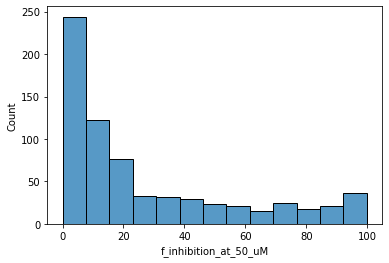

In [4]:
# Remove activators (inhibition < 0)
activity.dropna(subset=['f_inhibition_at_50_uM'], inplace=True)
activity = activity.query('f_inhibition_at_50_uM > 0 and f_inhibition_at_50_uM < 100')

# Label actives and inactives in relation to the fluorescence assay
activity['f_activity'] = activity['f_inhibition_at_50_uM'] > 50
activity['f_activity'] = activity['f_activity'].astype(int) # 1 for active, 0 for inactive

sns.histplot(x=activity['f_inhibition_at_50_uM'])

In [5]:
def rdkit_2d_coordinates(path, activity):
    from rdkit import Chem
    # Write into smiles
    activity[['SMILES','CID']].to_csv(f'{path}/smiles.smi', sep=' ', index=False, header=None)
    suppl = Chem.SmilesMolSupplier(f'{path}/smiles.smi')
    # Compute 2D coordinates
    coordinates = [x for x in suppl if x is not None]
    return coordinates

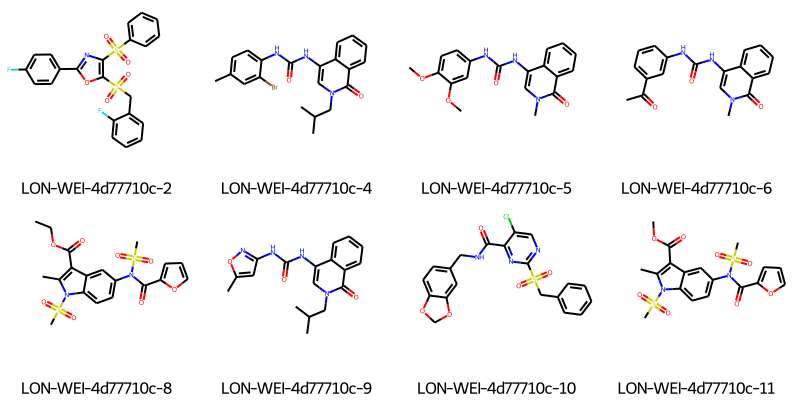

In [6]:
coordinates = rdkit_2d_coordinates(files, activity)

# Draw some of the molecules
from rdkit.Chem import Draw
Draw.MolsToGridImage(coordinates[:8],
        molsPerRow=4,
        subImgSize=(200,200),
        legends=[x.GetProp("_Name") for x in coordinates[:8]])

<a id='descriptors'></a>
### Molecular descriptors

In [7]:
def write_rdkit_descriptors(data, csv):
    from rdkit import Chem
    from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
    
    # Get molecules from SMILES
    mols = [Chem.MolFromSmiles(i) for i in data['SMILES']]

    # Get list of descriptors
    descriptors_list = [a[0] for a in Chem.Descriptors.descList]

    calculator = MolecularDescriptorCalculator(descriptors_list)
    calc_descriptors = [calculator.CalcDescriptors(m) for m in mols]

    descriptors = pd.DataFrame(calc_descriptors, columns=descriptors_list)
    descriptors['CID'] = data['CID'].tolist()
    
    # Rearrange columns
    cols = descriptors.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    descriptors = descriptors[cols]
    
    # Save to csv
    descriptors.to_csv(csv+'.gz', index=False, compression='gzip')

In [8]:
write_rdkit_descriptors(activity, files+'/descriptors.csv')

In [9]:
# Read descriptors
descriptors = pd.read_csv(f'{files}/descriptors.csv.gz', compression='gzip')
descriptors_list = list(descriptors.columns[1:])

<a id='read_docking'></a>
### Read docking results

In [10]:
# Read QuickVina02 results
qvina         = pd.read_csv(f'{files}/docking/qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv(f'{files}/docking/rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv(f'{files}/docking/plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv(f'{files}/docking/rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores
top = pd.merge(top_qvina, top_plants)

In [11]:
# Training and validation data
tmp = pd.merge(descriptors, top)
data = pd.merge(activity[['CID','f_activity']], tmp)
del tmp
data.head()

,CID,f_activity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qvina,rfscore_qvina,plants,rfscore_plants
0,MAT-POS-02ae579f-1,0,13.750736,-0.952041,13.750736,0.067957,0.303133,498.598,467.350,498.231871,...,0,0,0,0,0,0,-7.7,7.746907,-93.0745,7.544520
1,MAT-POS-02ae579f-2,0,11.889835,-0.425355,11.889835,0.271456,0.721190,267.292,254.188,267.112010,...,0,0,0,0,0,1,-7.2,6.285345,-80.1747,6.407342
2,LOR-NOR-f9b26152-1,0,13.428796,-0.812821,13.428796,0.001157,0.679037,195.149,189.101,195.033171,...,0,0,0,0,0,0,-5.5,4.929599,-59.7841,5.100658
3,MAT-POS-af71705c-2,0,12.761459,-0.371703,12.761459,0.051918,0.691028,403.486,378.286,403.200825,...,0,0,0,0,0,1,-8.3,7.213164,-80.6905,7.446774
4,JOH-UNI-591f77bd-1,0,12.296904,-1.020128,12.296904,0.132507,0.493403,355.843,337.699,355.064507,...,0,0,0,0,0,0,-5.9,6.262381,-75.5715,5.398284


In [12]:
# Test data // newer compounds
docking_compounds = data['CID']
test_data = activity[['CID','f_activity']].query('CID not in @docking_compounds')
test_data = pd.merge(test_data, descriptors)
test_data.to_csv(f'{files}/test_data.csv', index=False)

<a id='selecting'></a>
## Selecting molecular descriptors

In [13]:
y = data['f_activity']
X = data[descriptors_list]

In [14]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

var = VarianceThreshold(threshold=0.02)
X_transformed = MinMaxScaler().fit_transform(X)
var = var.fit(X_transformed, y)

# Select features with a high variance
cols = var.get_support(indices=True)
selected = X.columns[cols]
selected

Index(['MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       ...
       'fr_halogen', 'fr_ketone', 'fr_ketone_Topliss', 'fr_nitrile',
       'fr_para_hydroxylation', 'fr_piperdine', 'fr_piperzine', 'fr_pyridine',
       'fr_sulfonamd', 'fr_urea'],
      dtype='object', length=118)

In [15]:
# Drop highly correlated features
data.drop(['MolMR'], axis=1, inplace=True)
data.to_csv(f'{files}/data.csv', index=False)

descriptors.drop(['MolMR'], axis=1, inplace=True)
descriptors.to_csv(f'{files}/descriptors.csv', index=False)
descriptors_list = list(descriptors.columns[1:])

# Drop NaN values
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list
data.dropna(subset=trainset, inplace=True)

<a id='visualizing'></a>
## Visualizing the data

,f_activity,percentage
0,0,80.511182
1,1,19.488818


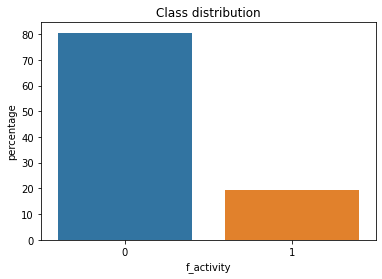

In [16]:
distribution = data['f_activity'].value_counts(
    normalize=True).mul(100).reset_index().rename({'f_activity':'percentage','index':'f_activity'}, axis=1)

sns.barplot(data=distribution, x='f_activity', y='percentage')
plt.title('Class distribution')
plt.savefig('figures/class-ditribution.png', dpi=128)
distribution

<a id='supplementary'></a>
## Supplementary data
<a id='regression'></a>
### Regression plot

Spearman R
qvina: 0.3712
plants: 0.0871


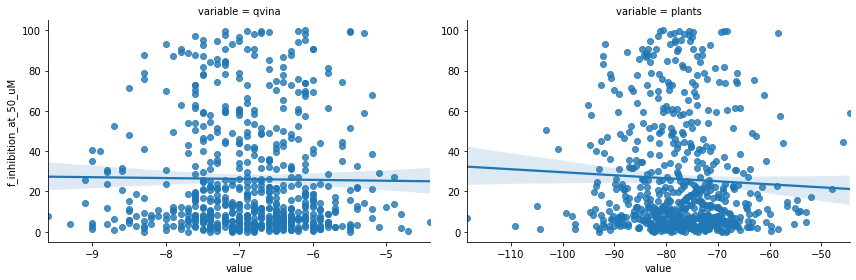

In [17]:
# Regression plot for "qvina" and the inhibition values from the fluorescence assay

from scipy.stats import spearmanr

df = pd.merge(data[['CID','qvina','plants']], activity[['CID','f_inhibition_at_50_uM']], on=['CID'])
print("Spearman R")
tmp = df.dropna(subset=['qvina', 'f_inhibition_at_50_uM'])
print(f"qvina: {spearmanr(tmp['qvina'], tmp['f_inhibition_at_50_uM'])[1]:.4f}")
tmp = df.dropna(subset=['plants', 'f_inhibition_at_50_uM'])
print(f"plants: {spearmanr(tmp['plants'], tmp['f_inhibition_at_50_uM'])[1]:.4f}")
del tmp

melt = pd.melt(df, id_vars=['CID','f_inhibition_at_50_uM'], value_vars=['qvina', 'plants'])
g = sns.FacetGrid(data=melt, col='variable', sharey=False, sharex=False, aspect=1.5, height=4)
g.map(sns.regplot, 'value', 'f_inhibition_at_50_uM')
plt.savefig('figures/docking_reg.png', dpi=128)

<a id='independent'></a>
### Test for class-independent features

In [49]:
from imblearn.over_sampling import SMOTE

y = data['f_activity']
X = data[descriptors_list]
X, y = SMOTE(random_state=42).fit_resample(X, y)

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_transformed = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X_transformed, columns=descriptors_list)

KBest = SelectKBest(score_func=chi2, k=5)
KBest = KBest.fit(X, y)

df_scores = pd.DataFrame({'features': X.columns, 'Chi2Score': KBest.scores_, 'pValue': KBest.pvalues_ })

In [56]:
# Select features that are more likely to be related to the activity
cols = KBest.get_support(indices=True)

# Add NumHAcceptors, NumHDonors and TPSA if they are not already in the list
selected = set(X.columns[cols].tolist() + ['NumHAcceptors', 'NumHDonors', 'TPSA', 'NumRotatableBonds'])
selected = list(selected)
print(selected)

['fr_urea', 'TPSA', 'NumAliphaticCarbocycles', 'fr_sulfonamd', 'PEOE_VSA5', 'NumHDonors', 'fr_NH2', 'NumHAcceptors', 'NumRotatableBonds']


In [57]:
df_selected = df_scores[df_scores['features'].isin(selected)]
df_selected

,features,Chi2Score,pValue
54,PEOE_VSA5,24.077922,9.251496e-07
107,NumAliphaticCarbocycles,24.750000,6.526880e-07
139,fr_NH2,29.454545,5.724362e-08
198,fr_sulfonamd,24.200000,8.683228e-07
206,fr_urea,34.886792,3.494433e-09


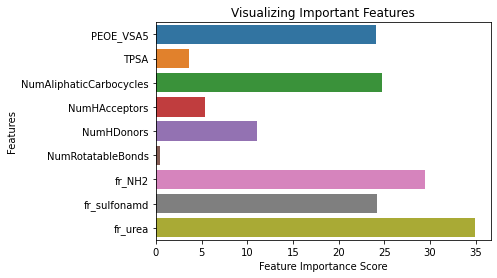

In [58]:
sns.barplot(x=df_selected['Chi2Score'], y=df_selected['features'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.savefig('figures/important_features.png', dpi=128)